In [10]:
import torch
from tqdm import tqdm
import math
# from .topology import small_world_connectivity
# from .utils import print_summary
# from .training import STDP
from neucube.topology import small_world_connectivity
from neucube.utils import print_summary
from neucube.training import STDP

class Reservoir():
  def __init__(self, cube_shape=(10,10,10), inputs=None, coordinates=None, mapping=None, c=0.4, l=0.169, c_in=0.9, l_in=1.2, input_conn_prob=0.95, use_mps=False):
    """
    Initializes the reservoir object.

    Parameters:
        cube_shape (tuple): Dimensions of the reservoir as a 3D cube (default: (10,10,10)).
        inputs (int): Number of input features.
        coordinates (torch.Tensor): Coordinates of the neurons in the reservoir.
                                    If not provided, the coordinates are generated based on `cube_shape`.
        mapping (torch.Tensor): Coordinates of the input neurons.
                                If not provided, random connectivity is used.
        c (float): Parameter controlling the connectivity of the reservoir.
        l (float): Parameter controlling the connectivity of the reservoir.
        c_in (float): Parameter controlling the connectivity of the input neurons.
        l_in (float): Parameter controlling the connectivity of the input neurons.
        use_mps (bool): use Metal Performance Shaders (MPS) for Apple Silicon (if available).
    """
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
    if torch.backends.mps.is_available() and use_mps is True:
      self.device = torch.device("mps:0")

    if coordinates is None:
      self.n_neurons = math.prod(cube_shape)
      x, y, z = torch.meshgrid(torch.linspace(0, 1, cube_shape[0]), torch.linspace(0, 1, cube_shape[1]), torch.linspace(0, 1, cube_shape[2]), indexing='xy')
      self.pos = torch.stack([x.flatten(), y.flatten(), z.flatten()], dim=1).to(self.device)
    else:
      self.n_neurons = coordinates.shape[0]
      self.pos = coordinates

    dist = torch.cdist(self.pos, self.pos)
    conn_mat = small_world_connectivity(dist, c=c, l=l) / 100
    self.inh_n = torch.randint(self.n_neurons, size=(int(self.n_neurons*0.2),))
    self.exc_n = torch.arange(self.n_neurons)[~torch.isin(torch.arange(self.n_neurons), self.inh_n)]

    conn_mat[:, self.inh_n] = -conn_mat[:, self.inh_n]

    if mapping is None:
      input_conn = torch.where(torch.rand(self.n_neurons, inputs) > input_conn_prob, torch.ones_like(torch.rand(self.n_neurons, inputs)), torch.zeros(self.n_neurons, inputs)) / 50
    else:
      dist_in = torch.cdist(coordinates, mapping, p=2)
      input_conn = small_world_connectivity(dist_in, c=c_in, l=l_in) / 50

    self.w_latent = conn_mat.to(self.device)
    self.w_in = input_conn.to(self.device)

    self.a, self.b = torch.full((self.n_neurons,), 0.02, dtype=torch.float64).to(self.device), torch.full((self.n_neurons,), 0.2, dtype=torch.float64).to(self.device)
    self.c, self.d = torch.full((self.n_neurons,), -65, dtype=torch.float64).to(self.device), torch.full((self.n_neurons,), 8, dtype=torch.float64).to(self.device)


  def simulate(self, X, mem_thr=30, dt=1, train=True, learning_rule=STDP(), verbose=True):
    """
    Simulates the reservoir activity given input data with izhikevich neurons.

    Parameters:
        X (torch.Tensor): Input data of shape (batch_size, n_time, n_features).
        mem_thr (float): Membrane threshold for spike generation.
        dt (float): time step for eulers method (lower results in more accurate dynamics).
        train (bool): Flag indicating whether to perform online training of the reservoir.
        learning_rule (LearningRule): The learning rule implementation to use for training.
        verbose (bool): Flag indicating whether to display progress during simulation.

    Returns:
        torch.Tensor: Spike activity of the reservoir neurons over time, of shape (batch_size, n_time, n_neurons).

    Raises:
        Exception: If learning rule implementation is not specified and training is enabled
    """
    if train is True and learning_rule is None:
      raise Exception("learning rule implementation must be specified if training is enabled")

    self.batch_size, self.n_time, self.n_features = X.shape
    total_steps = self.n_time  # Total number of sub-steps
    spike_rec = torch.zeros(self.batch_size, total_steps, self.n_neurons)
    self.I_rec = torch.zeros(self.batch_size, total_steps, self.n_neurons)
    self.mem_rec = torch.zeros(self.batch_size, total_steps, self.n_neurons)

    if train is True:
      learning_rule.setup(self.device, self.n_neurons)

    for s in tqdm(range(X.shape[0]), disable = not verbose):
      mem_poten = torch.full((self.n_neurons,), -70, dtype=torch.float64).to(self.device)
      u_recvr = self.b*mem_poten
      spike_latent = torch.zeros(self.n_neurons).to(self.device)
      spike_times = torch.zeros(self.n_neurons).to(self.device)

      if train is True:
        learning_rule.per_sample(s)

      for t in range(self.n_time):
        spike_in = X[s,t,:]
        spike_in = spike_in.to(self.device)

        # Izhikevich dynamics
        I = (torch.sum(self.w_in * spike_in, axis=1) + torch.sum(self.w_latent * spike_latent, axis=1)) *550
        u_recvr = u_recvr + dt * (self.a * (self.b * mem_poten - u_recvr))
        mem_poten = mem_poten + dt * (0.04 * mem_poten**2 + 5 * mem_poten + 140 - u_recvr + I)
        self.mem_rec[s, t, :] = mem_poten

        thres_met = mem_poten >= mem_thr
        mem_poten[thres_met] = self.c[thres_met]
        u_recvr[thres_met] = u_recvr[thres_met] + self.d[thres_met]

        spike_latent.fill_(0)
        spike_latent[thres_met] = 1
        spike_rec[s, t, :] = spike_latent
        self.I_rec[s, t, :] = I

      if train is True:
        learning_rule.per_time_slice(s, t)
        pre_updates, pos_updates = learning_rule.train(t-spike_times, self.w_latent, spike_latent)
        self.w_latent += pre_updates
        self.w_latent += pos_updates
        learning_rule.reset()

      spike_times[mem_poten >= mem_thr] = t

    spike_rec = spike_rec[:, :total_steps, :]
    return spike_rec
  
  def set_exc_parms(self, a=0.02, b=0.2, c=-65, d=8):
      self.a[self.exc_n] = a
      self.b[self.exc_n] = b
      self.c[self.exc_n] = c
      self.d[self.exc_n] = d

  def set_inh_parms(self, a=0.1, b=0.2, c=-65, d=2):      
      self.a[self.inh_n] = a
      self.b[self.inh_n] = b
      self.c[self.inh_n] = c  
      self.d[self.inh_n] = d
  
  def summary(self):
    """
    Prints a summary of the reservoir.
    """
    res_info = [["Neurons", str(self.n_neurons)],
                ["Reservoir connections", str(sum(sum(self.w_latent != 0)).item())],
                ["Input connections", str(sum(sum(self.w_in != 0)).item())],
                ["Device", str(self.device)]]

    print_summary(res_info)

In [11]:
import numpy as np
import pandas as pd
from neucube.encoder import Delta
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
import torch

filenameslist = ['sam'+str(idx)+'_eeg.csv' for idx in range(1,61)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/wrist_movement_eeg/'+filename, header=None))

fulldf = pd.concat(dfs)

labels = pd.read_csv('./example_data/wrist_movement_eeg/tar_class_labels.csv', header=None)
y = labels.values.flatten()

feat_names = pd.read_csv('./example_data/wrist_movement_eeg/feature_names_eeg.txt', header=None).values.flatten()
brain_coordinates = pd.read_csv('./example_data/wrist_movement_eeg/brain_coordinates.csv', header=None).values
eeg_mapping = pd.read_csv('./example_data/wrist_movement_eeg/eeg_mapping.csv', header=None).values

X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(threshold=0.8)
X = encoder.encode_dataset(X)
y = labels.values.flatten()

In [12]:
res = Reservoir(inputs=14, c=0.5, l=0.16, input_conn_prob=0.95)
res.summary()
print(res.w_in.count_nonzero(axis=0))

Neurons                1000  
Reservoir connections  13709 
Input connections      718   
Device                 cuda:0
tensor([60, 54, 51, 56, 57, 39, 65, 43, 49, 43, 49, 57, 41, 54],
       device='cuda:0')


In [13]:
res.set_exc_parms(a=0.02, b=0.2, c=-50, d=2)
res.set_exc_parms(a=0.02, b=0.55, c=-45, d=4) #more frequent chattering
res.set_inh_parms(a=0.1, b=0.2, c=-65, d=2)

out_spikes = res.simulate(X, mem_thr=30, dt=1, train=False, verbose=True)

100%|██████████| 60/60 [00:16<00:00,  3.70it/s]


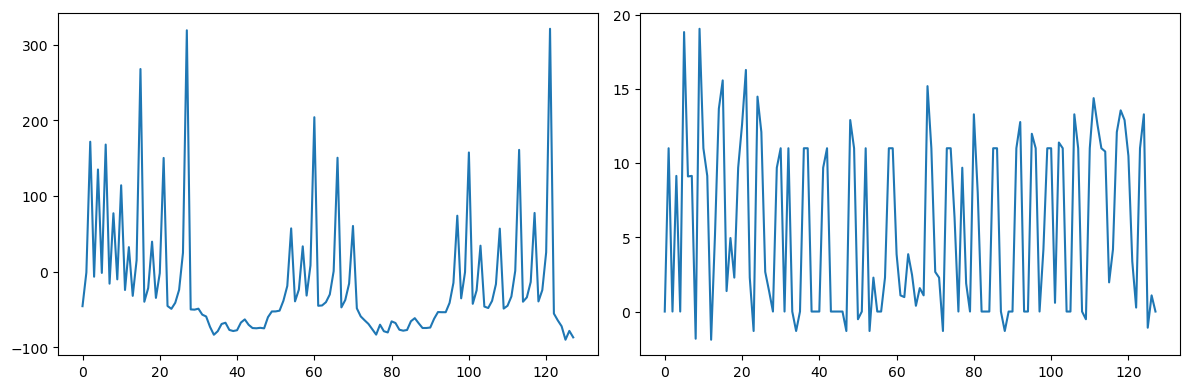

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(res.mem_rec[0][:, 20])
ax2.plot(res.I_rec[0][:, 20])
plt.tight_layout()
plt.show()

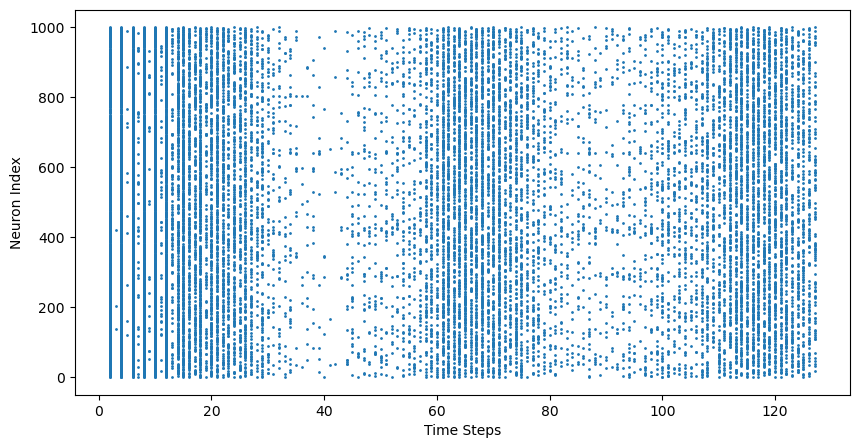

In [15]:
from neucube.visualise import spike_raster
spike_raster(out_spikes[0])

In [16]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from neucube.sampler import DeSNN

sampler = SpikeCount()
state_vec = sampler.sample(out_spikes)

# Define the number of folds
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    svm = SVC(kernel='linear')  # You can specify different kernels ('linear', 'poly', 'rbf', etc.)
    svm.fit(X_train_fold, y_train_fold)
    y_pred = svm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

0it [00:00, ?it/s]

10it [00:00, 134.41it/s]

10-Fold Cross-Validation Accuracy: 0.7166666666666667
[[14  6  0]
 [ 7 13  0]
 [ 1  3 16]]
